# Advertisement

### Problem Statement for the Advertising data  
* The dataset file consists of advertising expenditure incurred on different mediums and the overall increase in revenue that was seen during that time. 
* For any business, advertising their products is very essential because it aids in the fast selling of a product, increases the popularity and awareness of the product in the market, which in turn, increases the overall sales for the product. 
* But more than that, what matters for the business is that correct amount of investment should be done upon the advertisements such that it generates good return on investments otherwise it will just lead to an added expenditure.  
* The dataset contains statistics about the increase in sales of a product in 200 different months, together with advertising budgets in each of these months for different media channels: TV, radio and newspaper. 
* The budget and the increase in sales is in thousands of dollars.    
* You are expected to implement regression technique and predict what would be the increase in sales given the advertisement expenditure for that month.   
* You are free to use any ML algorithms, evaluate, fine tune and reach a best model.  
* Also derive additional/meaningful insights from the data which can help the organization to decide upon the right channels and amount of investments to be done on each media channel. 

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score,mean_squared_error
import statsmodels.formula.api as sm
import statsmodels.api as sma

In [2]:
# Read int the data into a DataFrame

data = pd.read_csv(r"Advertising.csv", 
                   index_col=0, header=0)
data.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [3]:
# Basic Data Exploration.

print("Data types: \n", data.dtypes)
print("\n\n\n The shape of the data: \n", data.shape)
print("\n\n\n Data description: \n\n", data.describe())

Data types: 
 TV           float64
radio        float64
newspaper    float64
sales        float64
dtype: object



 The shape of the data: 
, (200, 4)



 Data description: 

                TV       radio   newspaper       sales
count  200.000000  200.000000  200.000000  200.000000
mean   147.042500   23.264000   30.554000   14.022500
std     85.854236   14.846809   21.778621    5.217457
min      0.700000    0.000000    0.300000    1.600000
25%     74.375000    9.975000   12.750000   10.375000
50%    149.750000   22.900000   25.750000   12.900000
75%    218.825000   36.525000   45.100000   17.400000
max    296.400000   49.600000  114.000000   27.000000


* Above, we an see that we have 200 rows and 4 columns
* All columns have the data type of float
* Tv has a very high standard deiation, compared to other columns

In [4]:
# Checking for null data

data.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

* We do not have any missing values
* But there might be outliers

In [5]:
# Checking column names

data.columns

Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')

###  Assumption 1:

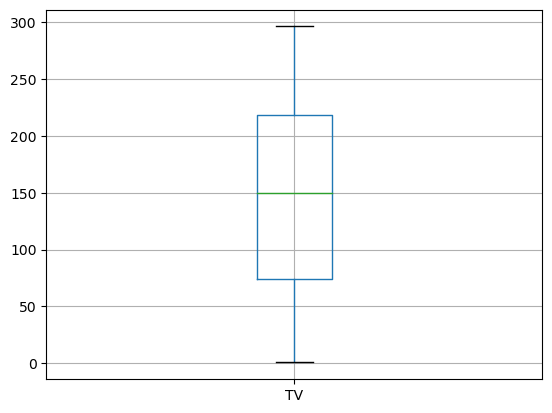

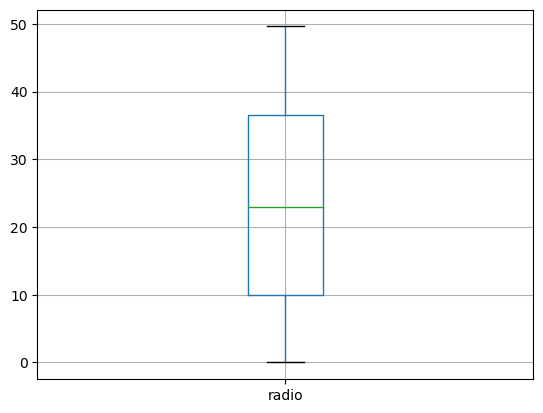

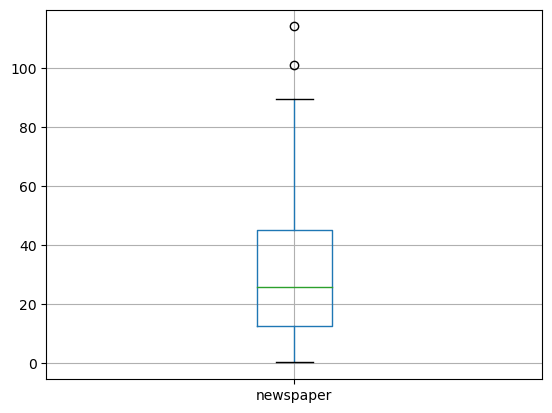

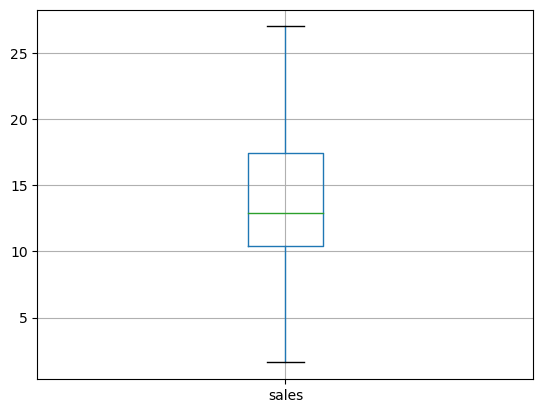

In [6]:
# Assumption 1: There should be no outliers in the data.
# Checked using boxplot.

for i in data.columns:
    data.boxplot(column=i)
    plt.show()

* We confirm that, the field: newspaper has outliers(2 points)
* We will handle these outliers later.  
* If the outliers are few and logically valid, we do not treat them.

### Assumption 2:

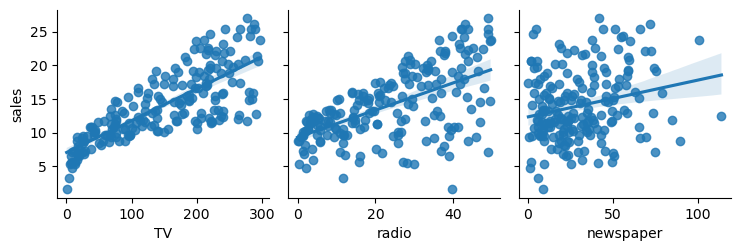

In [7]:
# Assumption 2: Assumption of linearity
# It states that every independent variables (X) should have a linear relationship with the dependent variable(Y).

sns.pairplot(data, x_vars=['TV', 'radio', 'newspaper'],
            y_vars="sales", kind='reg')
plt.show()

1. TV - Strong positive relation
2. Radio - moderate positive relation
3. Newspaper - No relation. 

<br>  

* TV and Radio, show a linear relationship, where as Newspaper is not showing a linear relationship.
* We can eleminate the two outliers from newspaper, as there is no relation (outliers will not affect relation). 
* But I chose to check the skewness first and maybe log transform the data as we have less data.

In [8]:
# creating X(Independent Variables) and Y(Dependent Variable)

X = data.iloc[:,0:-1]
Y = data.iloc[:,-1]

In [9]:
print(X.shape, "\n")
print(Y.shape)

(200, 3) 

(200,)


* X has 200 rows(all data) and 3 independent columns
* Y has 200 rows(all data) and 1 dependent columns

### Assumption 3:

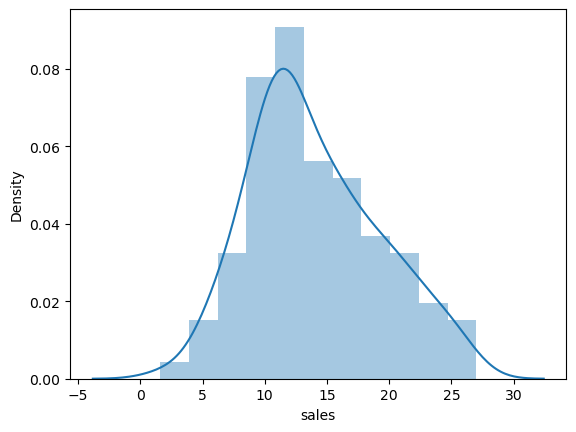

In [10]:
# Assumption 3: Assumption of Normality
# The dependent variable should follow an approximate normal distribution

sns.distplot(Y)
plt.show()

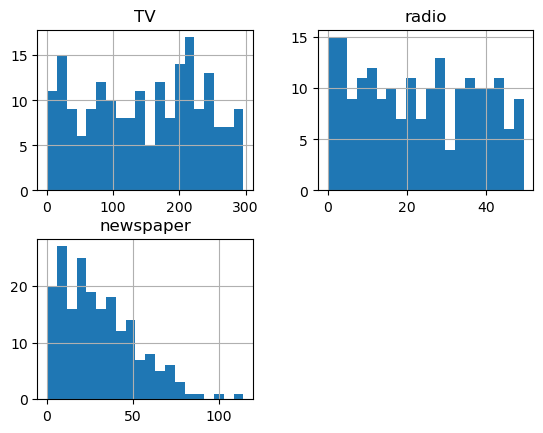

In [11]:
# Creating Histograms for the Independent variables

X.hist(bins=20)
plt.show()

In [12]:
# Checking the skewness and transforming highly skewed Features.

#from scipy.stats import skew

# Finding the skewness in each variable
data_num_skew = X.apply(lambda i: skew(i.dropna()))   # apply will iterate through X, 'i' will take each column once

# Subsetting the variabls that are highly skewed
data_num_skewed = data_num_skew[(data_num_skew > 0.75) | (data_num_skew < -0.75)]

print(data_num_skew, "\n\n")
print(data_num_skewed)

#import numpy as np

# apply log + 1 transformation for all numeric features with skewness over 0.75
X[data_num_skewed.index] = np.log1p(X[data_num_skewed.index])

TV          -0.069328
radio        0.093467
newspaper    0.887996
dtype: float64 


newspaper    0.887996
dtype: float64


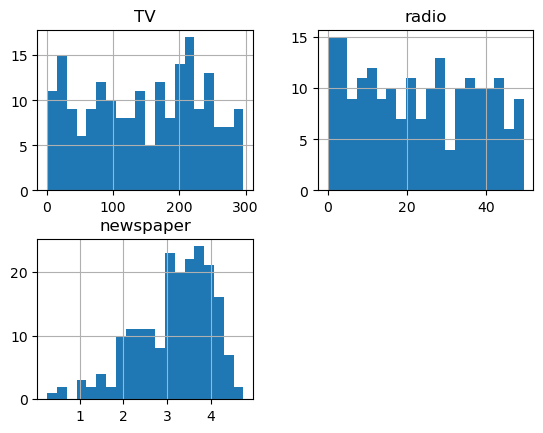

In [13]:
# Confirming that skewness is fixed

X.hist(bins=20)
plt.show()

### Assumption 4:

                 TV     radio  newspaper
TV         1.000000  0.054809   0.030951
radio      0.054809  1.000000   0.251909
newspaper  0.030951  0.251909   1.000000


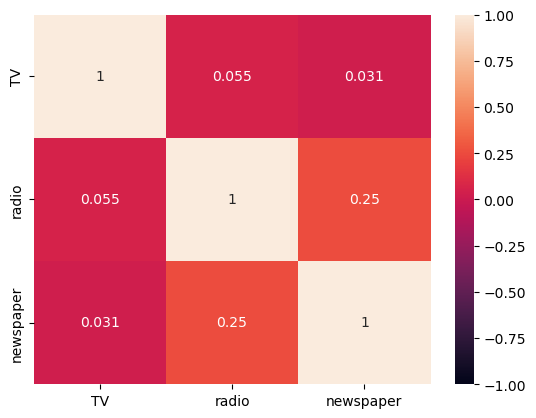

In [14]:
# Assumption 4: Assumption of no multicollinearity 
# There should be no multicollinearity between the independent variables.

corr_df=X.corr(method="pearson")
print(corr_df)

sns.heatmap(corr_df,vmax=1.0,vmin=-1.0,annot=True)
plt.show()

In [15]:
# Creating a DataFrame with the VIF values.

#from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

vif_df = pd.DataFrame()
vif_df["features"] = X.columns

vif_df["VIF Factor"] = [vif(X.values, i) for i in range(X.shape[1])]

vif_df.round(2)

,features,VIF Factor
0,TV,3.39
1,radio,3.63
2,newspaper,5.44


We go ahead and drop the newspaper column as the VIF > 5, it has two outliers and shows a poor relation to sales.

In [16]:
X.drop("newspaper", axis=1, inplace=True)

vif_df = pd.DataFrame()
vif_df["features"] = X.columns

vif_df["VIF Factor"] = [vif(X.values, i) for i in range(X.shape[1])]

vif_df.sort_values("VIF Factor",ascending=False, inplace=True)

vif_df.round(2)

,features,VIF Factor
0,TV,2.24
1,radio,2.24


* We confirm that the VIF values of TV and Radio improve by dropping the newspaper Feature.
* We will now follow the steps for ML modeling flow, viz. Training > Validation > Evaluation > Tuning.

### Splitting the data into Training data and Testing data.

In [17]:
#from sklearn.model_selection import train_test_split

# Splitting the data into test and train sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [18]:
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", Y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", Y_test.shape)

print("\nPercent of train data: ",X_train.shape[0]/X.shape[0]*100)

Shape of X_train:  (160, 2)
Shape of Y_train:  (160,)
Shape of X_test:  (40, 2)
Shape of Y_test:  (40,)

Percent of train data:  80.0


In [19]:
# Model building - LinearRegression

#from sklearn.linear_model import LinearRegression

# Creating a model object
lm = LinearRegression()

# Training the model
lm.fit(X_train, Y_train)

# Printing the Parameters (intercept and coefficients)
print("Intercept: ", lm.intercept_)
print("Slope Coefficients: ", lm.coef_)

Intercept:  3.2170261085129717
Slope Coefficients:  [0.04372065 0.19242472]


In [20]:
# Pairing the feature names with their respective coefficients
print(list(zip(X.columns, lm.coef_)))

[('TV', 0.043720648041688966), ('radio', 0.1924247165799466)]


### Predictions using the model.

In [21]:
Y_pred = lm.predict(X_test)
print(Y_pred)

[18.10549579 13.00696439 18.09578029 23.69803999 20.70228503 14.25602829
 14.93688357 21.418844   21.14310766 12.80131575 24.02246336  7.2230243
 12.36486517 19.24592959 19.46623318 13.40290827 19.55950449  9.20661663
 21.09644597 20.85811367 15.48792533 10.86764934 22.85776684 15.86934534
 17.41104133  8.21459064 11.84083864 12.72488631 21.69123531  7.94168761
 12.51565024 20.43974568  4.72722348  4.75607372 16.71555983 15.75710627
  6.72342208 17.68650834  9.04377293 13.59474227]


In [22]:
# Metrics

#from sklearn.metrics import r2_score,mean_squared_error
#import numpy as np

r2=r2_score(Y_test,Y_pred)  # R-Square value
print("R-squared:",r2)

rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("RMSE:", rmse)

adjusted_r_squared = 1 - (1-r2)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("Adj R-square:",adjusted_r_squared)

R-squared: 0.8354496662944216
RMSE: 2.587881707737811
Adj R-square: 0.8337791045309132


Above scores suggest that it is a Good/Ideal model.  
* R-square is close to 1 (high)
* R-square is similar to Adj R-square

In [23]:
# Building a Ridge model

#from sklearn.linear_model import Ridge
lm = Ridge(alpha=1.0)  # default: alpha = 1
lm.fit(X_train, Y_train)

# Printing the Parameters (intercept and coefficients)
print(lm.intercept_)
print(lm.coef_)

3.2171508278239767
[0.04372067 0.19241894]


In [24]:
Y_pred = lm.predict(X_test)

In [25]:
#from sklearn.metrics import r2_score, mean_squared_error
#import numpy as np

r2=r2_score(Y_test,Y_pred)  # R-Square value
print("R-squared:",r2)

rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("RMSE:", rmse)

adjusted_r_squared = 1 - (1-r2)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("Adj R-square:",adjusted_r_squared)

R-squared: 0.8354510844225151
RMSE: 2.5878705562695137
Adj R-square: 0.8337805370562462


In [26]:
# Building Lasso model

from sklearn.linear_model import Lasso
lm = Lasso()
lm.fit(X_train, Y_train)

# Printing the Parameters (intercept and coefficients)
print(lm.intercept_)
print(lm.coef_)

3.336794058220317
[0.04362374 0.18766033]


In [27]:
Y_pred = lm.predict(X_test)

In [28]:
#from sklearn.metrics import r2_score, mean_squared_error
#import numpy as np

r2=r2_score(Y_test,Y_pred)  # R-Square value
print("R-squared:",r2)

rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("RMSE:", rmse)

adjusted_r_squared = 1 - (1-r2)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("Adj R-square:",adjusted_r_squared)

R-squared: 0.8360506658527163
RMSE: 2.5831514271094234
Adj R-square: 0.8343862056075662


##### Linear Regression:
R-squared: 0.8354496662944216  
RMSE: 2.587881707737811  
Adj R-square: 0.8337791045309132  

##### Ridge:
R-squared: 0.8354510844225151  
RMSE: 2.5878705562695137  
Adj R-square: 0.8337805370562462  

##### Lasso:
R-squared: 0.8360506658527163  
RMSE: 2.5831514271094234  
Adj R-square: 0.8343862056075662

Here we see that Lasso regression gives us the 
* highest R-square and adj R-squared
* lowest RMSE

In [29]:
# Creating a temporary dataframe with X_test, Y_test ,Y-pred values and the deviation.

new_df=pd.DataFrame()
new_df=X_test.copy()

new_df["Actual sales"]=Y_test
new_df["Predicted sales"]=Y_pred
new_df=new_df.reset_index().drop("index", axis=1)

new_df["Deviation"] = abs(new_df["Actual sales"] - new_df["Predicted sales"])

new_df.head()

,TV,radio,Actual sales,Predicted sales,Deviation
0,210.7,29.5,18.4,18.064296,0.335704
1,8.7,48.9,7.2,12.892911,5.692911
2,218.4,27.7,18.0,18.062410,0.062410
3,283.6,42.0,25.5,23.590220,1.909780
4,216.4,41.7,22.6,20.602407,1.997593


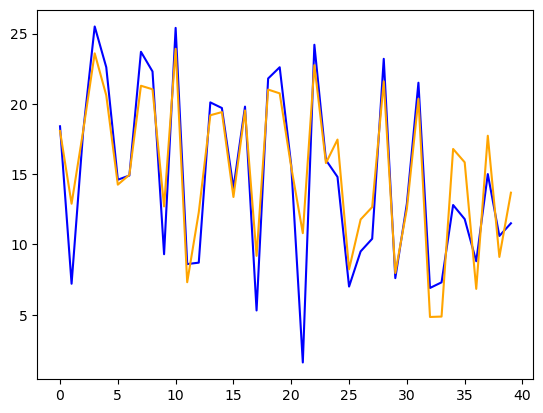

In [30]:
# Graphial representation - Comparison of "Actual sales" Vs "Predicted sales"
# Creating a line plot with Y_test and Y-pred values, to check/compare "Y_test and Y-pred values" Visually.

new_df["Actual sales"].plot(color='blue')
new_df["Predicted sales"].plot(color='orange')
plt.show()

In [31]:
# Creating a new DataFrame with the training data to build the OLS model.

new_df = pd.DataFrame()
new_df = X_train.copy()

new_df["sales"] = Y_train.copy()
new_df.shape

(160, 3)

In [32]:
#import statsmodels.formula.api as sm

# creating a fitted model with all features
ols = sm.ols(formula='sales ~ TV + radio', data=new_df).fit()

# Printing the Parameters and OLS summary
print(ols.params)
print(ols.summary())

Intercept    3.217026
TV           0.043721
radio        0.192425
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     912.9
Date:                Sun, 16 Jul 2023   Prob (F-statistic):           3.47e-87
Time:                        13:20:54   Log-Likelihood:                -276.70
No. Observations:                 160   AIC:                             559.4
Df Residuals:                     157   BIC:                             568.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

* Here we see that Durbin-Watson: 2.1 (close to 2), hence we conclude that there is no auto-correlation.

In [33]:
# Predicting using the OLS model
Y_pred_new = ols.predict(X_test)

#from sklearn.metrics import r2_score, mean_squared_error
#import numpy as np

r2=r2_score(Y_test,Y_pred_new)  # R-Square value
print("R-squared:",r2)

rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_new))
print("RMSE:", rmse)

adjusted_r_squared = 1 - (1-r2)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("Adj R-square:",adjusted_r_squared)

R-squared: 0.8354496662944217
RMSE: 2.5878817077378105
Adj R-square: 0.8337791045309133


### Assumption 5

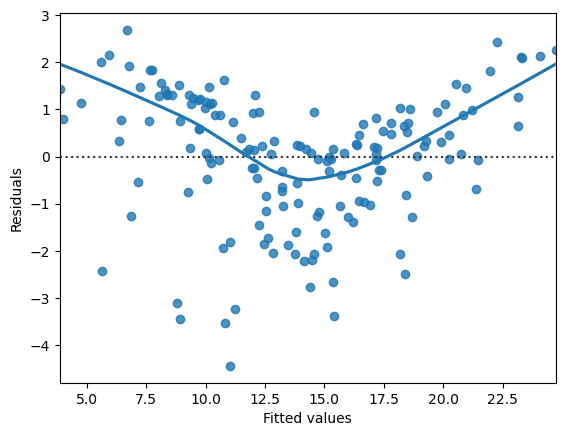

In [34]:
# Assumption 5: Errors should be random
# Checked using Residual v/s Fitted plot

model_fitted_y = ols.fittedvalues
sns.residplot(x=model_fitted_y, y='sales', data=new_df, lowess=True)  # lowess=True is to plot the curved line.
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# The line should be a random line and should not follow a wave like pattern.

### Assumption 6

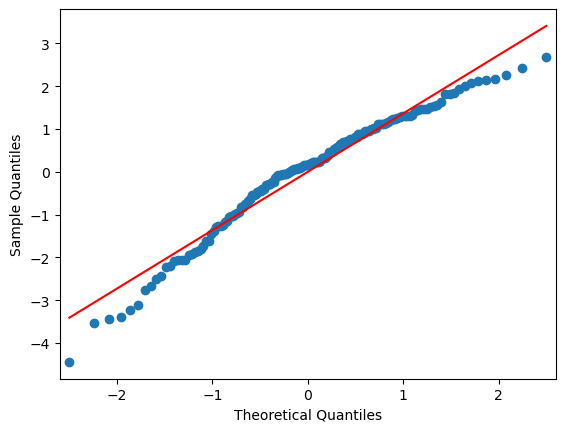

In [35]:
# Assumption 6: Errors should follow an approximate normal distribution
# Checked using Normal QQ plot (Quantile-Quantile Plot).

#import statsmodels.api as sma
sma.qqplot(ols.resid, line='s')  # line='s' > standardized line
plt.show()

# The error points should follow the red diagonal line, if not, then the errrors are skewed.

### Assumption 7

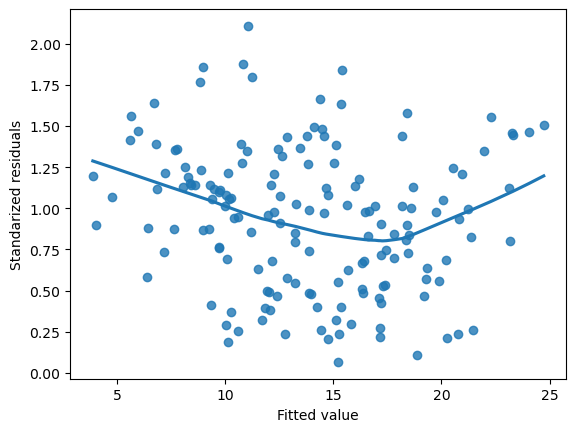

In [36]:
# Assumption 7: Errors should follow a constant variance-->Homoskedasticity
# Checked using Scale location plot

model_norm_residuals_abs_sqrt=np.sqrt(np.abs(ols.resid))

sns.regplot(x=ols.fittedvalues, y=model_norm_residuals_abs_sqrt, scatter=True, lowess=True)        
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")
plt.show()

# The line follows a slight curve and not a steep V like curve
# Hence, we confirm that the errors follow a constant variance

* We conclude that Lasso regression gives us the best scores, compared to all above models  
* Higest R-squared and adj R-squared and lowest RMSE.  
*  In future, we will use Lasso regression to predict the values for this data.

* We go ahead and finalise the model
* We will predict the values and dump it to a csv.

In [37]:
#from sklearn.linear_model import Lasso
lm = Lasso()
lm.fit(X_train, Y_train)

Y_pred = lm.predict(X_test)

In [38]:
# Creating a dataframe with X_test, Y_test ,Y-pred values and the deviation.

new_df=pd.DataFrame()
new_df=X_test.copy()

new_df["Actual sales"]=Y_test
new_df["Predicted sales"]=Y_pred
new_df=new_df.reset_index().drop("index", axis=1)

new_df["Deviation"] = abs(new_df["Actual sales"] - new_df["Predicted sales"])

new_df.head()

,TV,radio,Actual sales,Predicted sales,Deviation
0,210.7,29.5,18.4,18.064296,0.335704
1,8.7,48.9,7.2,12.892911,5.692911
2,218.4,27.7,18.0,18.062410,0.062410
3,283.6,42.0,25.5,23.590220,1.909780
4,216.4,41.7,22.6,20.602407,1.997593


In [39]:
new_df.to_csv("Predicted_sales.csv")

### End of project